In [ ]:
%reload_ext autoreload
%autoreload 2

import h5py
import json
import numpy as np
import pandas as pd
import scipy.stats
from pathlib import Path
from itertools import product

import sklearn.model_selection
import tensorflow as tf

from tqdm.auto import tqdm
tqdm.get_lock().locks = []

from IPython.display import Image, display, HTML, Math, Latex
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import seaborn as sns
import altair as alt

import plotly
import plotly.express as px
import plotly.offline as ply
import plotly.graph_objs as plygo
import cufflinks as cf

plotly.io.orca.config.executable = '/home/kiran/.local/bin/orca'
ply.init_notebook_mode(connected=False)
cf.set_config_file(offline=True, world_readable=False, theme='white')

In [ ]:
from hsi_deeplearning.hsi_dataset import HSIDataset
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
datasets = {'Suburban': '/storage/kiran/data/suburban/20170820_Urban_Ref_Reg_Subset.tif',
            'Urban': '/storage/kiran/data/urban/20170820_Urban2_INT_Final.tif',
            'Forest': '/storage/kiran/data/forest/20170820_Forest_Final_INT.tif'        
}

# Collect results from H5 files

In [ ]:
h5_files = list(Path('/storage/kiran/results/data/').glob('pred*.h5'))
metrics = pd.DataFrame()
l = widgets.Label(value="Not started...")
display(l)
for path in tqdm(h5_files[:]):
    l.value = f"{path}"
    try:
        h5_file = h5py.File(path, 'r')    
    except Exception as e:
        print(f"Could not oopen file: {path}")
        raise e
        
    attrs = dict(h5_file.attrs.items())    

#     dataset_name = attrs['dataset_name']
#     input_type = attrs['input_type']
#     compression_class = attrs['compression_class']

#     n_components = attrs['n_components']
#     compression_rate = attrs['compression_rate']*100
#     reconstruction_loss = attrs['reconstruction_loss']
    
    execution_times = json.loads(attrs['execution_times'])
    
    df_attrs = pd.DataFrame.from_dict(attrs, orient="index").T
    df_timers = pd.DataFrame.from_dict(execution_times, orient='index').T
    df_timers.columns = [ f"time_{c}" for c in  df_timers.columns ]
    df_timers = df_timers.diff(axis=1)
    df_timers.dropna(inplace=True, axis=1)
    df = pd.concat([df_attrs, df_timers],  axis=1)    
    del df['execution_times']
    metrics = pd.concat([metrics, df])
    l.value = f"{path} {metrics.shape}" 

In [5]:
# metrics.to_pickle('/storage/kiran/results/execution_times.pickle')
# metrics = pd.read_pickle('/storage/kiran/results/execution_times.pickle')
display(metrics)

,compression_class,compression_rate,dataset_name,input_type,n_components,reconstruction_loss,repetition,time_train_compression,time_compression,time_reconstruction,time_train_classifier,time_test_classifier,time_load_data
0,AE,0.96,Forest,HSI_SG,10,0.0118057,8,471.595585,0.017292,0.005417,0.066904,0.025623,NaN
0,AE,0.57,Forest,HSI,107,7.57699e-05,2,130.210558,0.022142,0.007184,0.499365,0.046530,NaN
0,DAE,0.99,Urban,HSI_SG,3,0.0304005,8,1073.470127,0.043637,0.016017,0.069023,0.038413,NaN
0,KPCA,0.46,Urban,HSI_SG,162,0.00133491,1,1272.860260,36.480636,15.468336,4.728097,0.130105,NaN
0,PCA,0.58,Urban,HSI,126,1.27804e-05,1,1.328879,0.076640,0.016994,4.116169,0.110895,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,AE,0.18,Forest,HSI,205,8.28941e-05,4,253.062885,0.023662,0.009051,0.831727,0.081076,NaN
0,PCA,0.41,Forest,HSI_SG,148,1.70803e-08,1,0.800031,0.032301,0.015113,0.883048,0.061028,NaN
0,AE,0.95,Urban,HSI,15,0.00399693,1,92.010328,0.039024,0.010367,0.523989,0.050885,NaN
0,DAE,0.91,Suburban,HSI_SG,27,0.000899811,7,657.108760,0.059902,0.023494,1.727496,0.082608,NaN


Saving: /storage/kiran/results/charts/execution_times.png


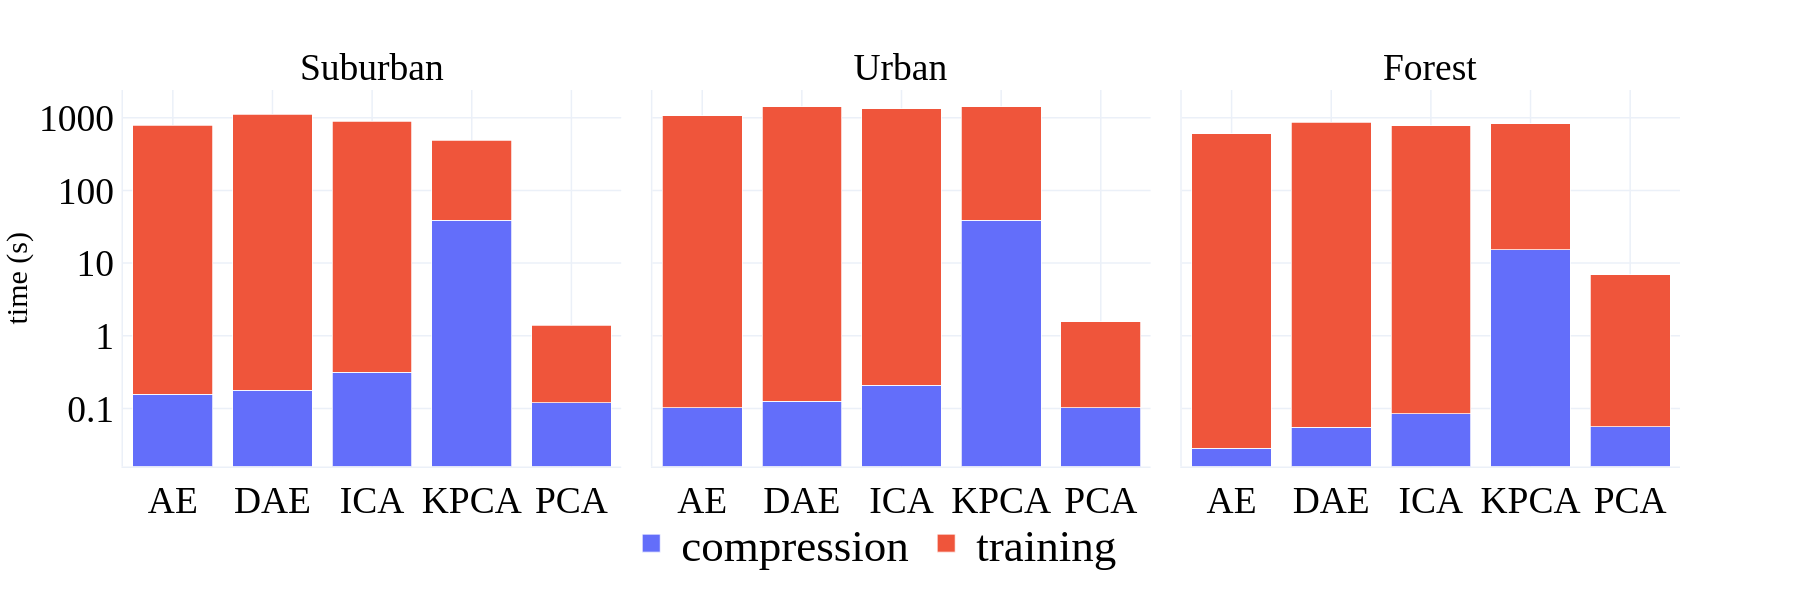

In [6]:
d = metrics.copy()
#d = d[d.compression_class.isin(['PCA','SKLPCA'])]
# display(d)

# d.time_train_compression[d.compression_class=='PCA'] = 10
# d.time_compression[d.compression_class=='PCA'] = 10
# d.time_reconstruction[d.compression_class=='PCA'] = 10

# d.time_train_compression[d.compression_class=='SKLPCA'] = 10
# d.time_compression[d.compression_class=='SKLPCA'] = 10
# d.time_reconstruction[d.compression_class=='SKLPCA'] = 10

d = d.groupby(['dataset_name','compression_class']).agg({'time_train_compression':'max', 'time_compression': 'max'})
# del d['time_test_classifier']
# del d['time_train_classifier']
# del d['time_reconstruction']
#display(d)

d.columns = [f"{c.replace('time_','')}" for c in d.columns]
d.columns = [f"{c.replace('train_compression','training')}" for c in d.columns]
d = d.reset_index().melt(id_vars=['compression_class','dataset_name'], var_name='timer', value_name='time')
d.columns = [f"{c.replace('compression_class','algorithm')}" for c in d.columns]

fig = px.bar(d, x='algorithm', y='time', color='timer', facet_col='dataset_name', 
             barmode='stack',
             log_y=True, 
             log_x=False,
             category_orders = {'dataset_name':['Suburban','Urban','Forest'],
                               'timer':['compression', 'training']},
             template='plotly_white'
            )

# fig.update_layout(barmode='overlay', xaxis={'categoryorder':'category descending'})

fig.for_each_annotation(lambda a: a.update(text=a.text.replace("input_type=", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("dataset_name=", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("timer", "")))
fig.for_each_trace(lambda t: t.update(name=t.name.replace("compression_", "")))
fig.update_layout(legend_title="", font=dict(size=25, color="Black", family='Times New Roman'))
fig.update_xaxes(nticks=6, title_standoff=0, title_font=dict(size=20, family='Times New Roman'))
fig.update_yaxes(nticks=6, title_standoff=0, title_font=dict(size=20, family='Times New Roman'))
fig.layout.xaxis.title.text = fig.layout.xaxis2.title.text = fig.layout.xaxis3.title.text = ""
fig.layout.yaxis.title.text  = "time (s)"

fig.update_layout(
    legend=dict(
        x=0.32,
        y=-0.1,
        # traceorder="reversed",
        title_font_family="Times New Roman",
        font=dict(
            family="Times New Roman",
            size=30,
            color="black"
        ),
        bgcolor='rgba(255, 255, 255, 0)',
        # bordercolor="Black",
        borderwidth=0,
        orientation='h'
    )
)

# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)'})
# fig.show()

filename= f'/storage/kiran/results/charts/execution_times.png'
print(f"Saving: {filename}")
fig.write_image(filename, width=1200, height=400, scale=1.5)
Image(filename)

,algorithm,dataset_name,time
0,AE,Forest,0.028211
1,AE,Suburban,0.157920
2,AE,Urban,0.101874
3,DAE,Forest,0.054805
4,DAE,Suburban,0.177799
5,DAE,Urban,0.125017
6,ICA,Forest,771.527963
7,ICA,Suburban,897.828526
8,ICA,Urban,1327.691409
9,KPCA,Forest,832.143976


Saving: /storage/kiran/results/charts/scalability_execution_times.png


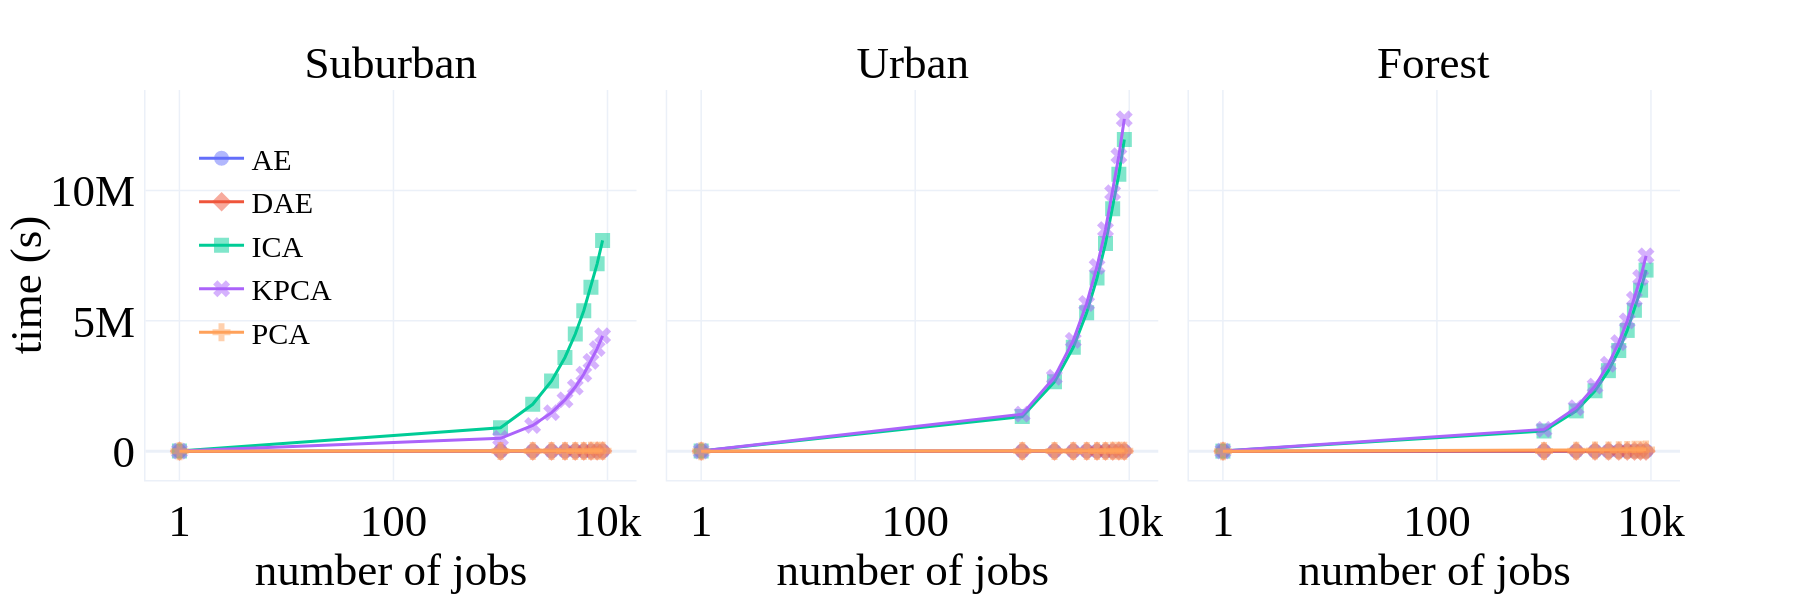

In [16]:
filt = ( ((d.algorithm=='AE') | (d.algorithm=='DAE')) & (d.timer=='compression') )
filt |= ( (d.algorithm=='KPCA') | (d.algorithm=='ICA') | (d.algorithm=='PCA') )

d2 = d[filt].groupby(['algorithm','dataset_name']).agg({'time':'sum'}).reset_index()

display(d2)

scale_d = []
for n_jobs in range(1,10000,1000):
    d2['n_jobs'] = n_jobs
    scale_d.append(d2.copy())

scale_d = pd.concat(scale_d)
scale_d.eval('time=n_jobs * time', inplace=True)
fig = px.scatter(data_frame=scale_d, 
                 x='n_jobs', 
                 y='time', 
                 color='algorithm', 
                 symbol='algorithm', 
                 facet_col='dataset_name', 
                 log_x=True,
                 log_y=False,
                 template='plotly_white',
                 category_orders = {'dataset_name':['Suburban','Urban','Forest'],
                                    'timer':['compression', 'training']
                                   }                
                )
fig.update_traces(hoverinfo='text+name', mode='lines+markers')
fig.update_traces(marker=dict(size=10, opacity=0.5))

fig.for_each_annotation(lambda a: a.update(text=a.text.replace("input_type=", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("dataset_name=", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("timer", "")))
fig.for_each_trace(lambda t: t.update(name=t.name.replace("compression_", "")))
fig.update_layout(legend_title="", font=dict(size=30, color="Black", family='Times New Roman'))
fig.update_yaxes(nticks=6, title_standoff=0, title_font=dict(size=30, family='Times New Roman'))
fig.update_xaxes(nticks=3, title_standoff=0, title_font=dict(size=30, family='Times New Roman'))
fig.layout.xaxis.title.text = fig.layout.xaxis2.title.text = fig.layout.xaxis3.title.text = "number of jobs"
fig.layout.yaxis.title.text  = "time (s)"

fig.update_layout(
    legend=dict(
        x=0.03,
        y=0.9,
        # traceorder="reversed",
        title_font_family="Times New Roman",
        font=dict(
            family="Times New Roman",
            size=20,
            color="black"
        ),
        bgcolor='rgba(255, 255, 255, 0)',
        # bordercolor="Black",
        borderwidth=0,
        orientation='v'
    )
)

filename= f'/storage/kiran/results/charts/scalability_execution_times.png'
print(f"Saving: {filename}")
fig.write_image(filename, width=1200, height=400, scale=1.5)
Image(filename)